# Single-Cell RNA-seq Workflow with kb-python
## Kaggle Notebook Edition (GPU-Enabled Environment)

This notebook demonstrates a complete single-cell RNA-seq preprocessing pipeline using **kb-python** (kallisto|bustools) optimized for Kaggle's cloud environment. The workflow covers:

1. **Environment Setup** — Installing dependencies within Kaggle constraints
2. **Reference Building** — Generating kallisto index and transcript-to-gene mapping
3. **Data Acquisition** — Downloading small demonstration FASTQ files
4. **Pseudoalignment & Quantification** — Running kb count on multiple samples
5. **Data Loading & Merging** — Combining samples into a unified AnnData object

---

### ⚠️ Kaggle-Specific Constraints

| Resource | Limit | Impact on Workflow |
|----------|-------|-------------------|
| **Disk Space** | 20 GB (working) | Use small datasets, clean temp files |
| **RAM** | 29-30 GB | Excellent for large count matrices |
| **GPU** | T4 (30 hrs/week) | Not used by kb-python (CPU-based) |
| **Session Time** | 12 hours max | Sufficient for small-medium datasets |
| **Idle Timeout** | ~20-60 min | Keep notebook active during long runs |

**Pro Tip:** For larger datasets, upload FASTQs as a **Kaggle Dataset** — files in `/kaggle/input/` don't count against your 20 GB working directory limit!

---

### Dataset Selection

We use the **kb-python tutorial dataset** (mouse retina, ~100 MB) for this demonstration. This ensures the complete workflow runs within Kaggle's disk constraints while demonstrating all key concepts.

For human brain data, see the **Appendix** section for accession numbers and download instructions.

In [1]:
# =============================================================================
# CELL 1: Check Kaggle Environment Resources
# =============================================================================
# First, let's verify our environment and available resources.

import os
import shutil

print("="*70)
print("KAGGLE ENVIRONMENT CHECK")
print("="*70)

# Check if we're on Kaggle
IS_KAGGLE = os.path.exists('/kaggle')
print(f"\n✓ Running on Kaggle: {IS_KAGGLE}")

# Check disk space
if IS_KAGGLE:
    working_path = '/kaggle/working'
    input_path = '/kaggle/input'
else:
    # Fallback for local testing
    working_path = os.getcwd()
    input_path = os.getcwd()

total, used, free = shutil.disk_usage(working_path)
print(f"\nDisk Space ({working_path}):")
print(f"  Total:     {total / (1024**3):.1f} GB")
print(f"  Used:      {used / (1024**3):.1f} GB")
print(f"  Available: {free / (1024**3):.1f} GB")

# Check RAM
try:
    with open('/proc/meminfo', 'r') as f:
        meminfo = f.read()
    mem_total = int([x for x in meminfo.split('\n') if 'MemTotal' in x][0].split()[1]) / (1024**2)
    print(f"\nRAM: {mem_total:.1f} GB")
except:
    print("\nRAM: Unable to detect")

# Check CPU cores
import multiprocessing
print(f"CPU Cores: {multiprocessing.cpu_count()}")

# Check GPU
try:
    import subprocess
    result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], 
                          capture_output=True, text=True)
    if result.returncode == 0:
        print(f"GPU: {result.stdout.strip()}")
        print("     (Note: kb-python is CPU-based and won't use GPU)")
except:
    print("GPU: Not detected or not available")

print("\n" + "="*70)

KAGGLE ENVIRONMENT CHECK

✓ Running on Kaggle: True

Disk Space (/kaggle/working):
  Total:     19.5 GB
  Used:      0.0 GB
  Available: 19.5 GB

RAM: 31.4 GB
CPU Cores: 4
GPU: Not detected or not available



In [3]:
# =============================================================================
# CELL 2: Install Required Packages
# =============================================================================
# Kaggle notebooks reset between sessions, so we install packages fresh each time.
# The -q flag suppresses verbose output for cleaner logs.

%time

print("Installing required packages...\n")

# Install packages (suppress output with -q)
!pip install -q kb-python ffq scanpy leidenalg python-igraph anndata gget

print("\n" + "="*60)
print("Package installation complete!")
print("="*60)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
Installing required packages...

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.5/36.5 MB 32.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 68.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 MB 41.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 76.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 53.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 33.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━

In [4]:
# =============================================================================
# CELL 3: Verify Installation
# =============================================================================
# Confirm kb-python and its bundled tools are working correctly.

print("Verifying kb-python installation...\n")
!kb info

print("\n" + "-"*60)
print("Python package versions:")
print("-"*60)

import scanpy as sc
import anndata

print(f"  scanpy:  {sc.__version__}")
print(f"  anndata: {anndata.__version__}")

Verifying kb-python installation...

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():
kb_python 0.29.5
kallisto: 0.51.1 (/usr/local/lib/python3.12/dist-packages/kb_python/bins/linux/kallisto/kallisto)
bustools: 0.45.1 (/usr/local/lib/python3.12/dist-packages/kb_python/bins/linux/bustools/bustools)
kb is a python package for rapidly pre-processing single-cell RNA-seq data. It
is a wrapper for the methods described in [2].

The goal of the wrapper is to simplify downloading and running of the kallisto
[1] and bustools [2] programs. It was inspired by Sten Linnarsson’s loompy
fromfq command (http://linnarssonlab.org/loompy/kallisto/index.html)

The kb program consists of three parts:

The `kb ref` command builds or downloads a species-specific index for
pseudoalignment of reads. This command must be run prior to `kb count`, and it
runs the `kallisto index` [1].

The `kb count` com

/tmp/ipykernel_55/1072903284.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print(f"  scanpy:  {sc.__version__}")
/tmp/ipykernel_55/1072903284.py:17: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  print(f"  anndata: {anndata.__version__}")


In [5]:
# =============================================================================
# CELL 4: Define Directory Structure
# =============================================================================
# Kaggle paths are fixed - we work within /kaggle/working/
# Files in /kaggle/input/ (Kaggle Datasets) are read-only but don't count against disk quota.

from pathlib import Path

# Kaggle-specific paths
if os.path.exists('/kaggle'):
    WORKING_DIR = Path('/kaggle/working')
    INPUT_DIR = Path('/kaggle/input')  # Read-only, for Kaggle Datasets
else:
    # Fallback for local testing
    WORKING_DIR = Path.cwd() / 'kaggle_simulation'
    INPUT_DIR = WORKING_DIR / 'input'

# Define subdirectories within working directory
DIRS = {
    "root": WORKING_DIR,
    "reference": WORKING_DIR / "reference",
    "raw_data": WORKING_DIR / "raw_data",
    "output": WORKING_DIR / "output",
    "processed": WORKING_DIR / "processed_data",
    "results": WORKING_DIR / "results"
}

# Create directories
print(f"Setting up project structure in: {WORKING_DIR}\n")
for name, path in DIRS.items():
    path.mkdir(parents=True, exist_ok=True)
    print(f"  📁 {name}: {path}")

os.chdir(WORKING_DIR)
print(f"\n✓ Working directory: {os.getcwd()}")

Setting up project structure in: /kaggle/working

  📁 root: /kaggle/working
  📁 reference: /kaggle/working/reference
  📁 raw_data: /kaggle/working/raw_data
  📁 output: /kaggle/working/output
  📁 processed: /kaggle/working/processed_data
  📁 results: /kaggle/working/results

✓ Working directory: /kaggle/working


---

## Part 2: Build Reference Index

The **kb ref** command downloads the transcriptome and builds a kallisto index.

**For this tutorial, we use MOUSE reference** (the tutorial FASTQs are mouse retina data).

| Organism | Flag | Index Size | Build Time |
|----------|------|------------|------------|
| Mouse | `-d mouse` | ~3 GB | 10-15 min |
| Human | `-d human` | ~3 GB | 10-15 min |

**⚠️ Disk Space Note:** The index and transcriptome files will use ~4-5 GB. Monitor your disk usage!

In [6]:
# =============================================================================
# CELL 5: Build Mouse Reference Index
# =============================================================================
# For the tutorial dataset, we need MOUSE reference.
# Change to "human" if using human PBMC or brain data.

%time

ORGANISM = "human"  # Change to "human" for human data

index_path = DIRS["reference"] / "index.idx"
t2g_path = DIRS["reference"] / "t2g.txt"

# Check if reference already exists
if index_path.exists() and t2g_path.exists():
    print(f"✓ {ORGANISM.capitalize()} reference already exists. Skipping build.")
    print(f"  Index: {index_path}")
    print(f"  T2G:   {t2g_path}")
else:
    print(f"Building {ORGANISM} reference index...")
    print("This will take 10-15 minutes. The progress bar may pause during download.\n")
    
    !kb ref -d {ORGANISM} \
        -i {index_path} \
        -g {t2g_path}
    
    print("\n" + "="*60)
    print(f"✓ {ORGANISM.capitalize()} reference built successfully!")
    print("="*60)

# Check disk usage after building reference
_, _, free = shutil.disk_usage(WORKING_DIR)
print(f"\n📊 Remaining disk space: {free / (1024**3):.1f} GB")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs
Building human reference index...
This will take 10-15 minutes. The progress bar may pause during download.

[2025-12-25 10:01:26,796]    INFO [download] Downloading files for human (standard workflow) from https://github.com/pachterlab/kallisto-transcriptome-indices/releases/download/v1/human_index_standard.tar.xz to tmp/human_index_standard.tar.xz
100%|█████████████████████████████████████████| 138M/138M [00:01<00:00, 120MB/s]
[2025-12-25 10:01:28,003]    INFO [download] Extracting files from tmp/human_index_standard.tar.xz

✓ Human reference built successfully!

📊 Remaining disk space: 19.1 GB


In [7]:
# =============================================================================
# CELL 6: Clean Up Downloaded Transcriptome (Optional - Saves ~2GB)
# =============================================================================
# The kb ref command downloads the transcriptome FASTA which isn't needed after
# index building. Delete it to save disk space.

import glob

# Find and remove transcriptome files (keep only index.idx and t2g.txt)
transcriptome_files = glob.glob(str(DIRS["reference"] / "*.fa*"))  # .fa, .fasta, .fa.gz
transcriptome_files += glob.glob(str(DIRS["reference"] / "*.cdna*"))

if transcriptome_files:
    print("Cleaning up temporary transcriptome files to save disk space...\n")
    for f in transcriptome_files:
        size_mb = os.path.getsize(f) / (1024**2)
        os.remove(f)
        print(f"  🗑️ Removed: {os.path.basename(f)} ({size_mb:.1f} MB)")
    
    _, _, free = shutil.disk_usage(WORKING_DIR)
    print(f"\n📊 Disk space after cleanup: {free / (1024**3):.1f} GB")
else:
    print("✓ No transcriptome files to clean up.")

✓ No transcriptome files to clean up.


---

## Part 3: Download FASTQ Data

We use the **ultra-small kb-python tutorial dataset** (mouse retina) for this Kaggle notebook:

- **Total size:** ~100 MB
- **Cells:** ~3,500
- **Processing time:** ~10-15 minutes
- **Chemistry:** 10x Chromium v2

This keeps us well within Kaggle's 20 GB disk limit while demonstrating the complete workflow.

For larger datasets, consider:
1. Uploading FASTQs as a **Kaggle Dataset** (files in `/kaggle/input/` are free)
2. Using the SRA toolkit to stream data directly

In [8]:
# =============================================================================
# CELL 7: Download Tutorial FASTQ Files
# =============================================================================
# These are the official kb-python tutorial FASTQs (mouse retina, 10x v2).
# We create three "samples" to demonstrate the multi-sample merging workflow.

%time

import urllib.request

# Define sample structure
# For demonstration, we simulate 3 conditions using the same base data
# In a real experiment, each would have unique FASTQ files
SAMPLES = {
    "sample_control": {
        "condition": "control",
        "timepoint": "0h",
        "r1_url": "https://caltech.box.com/shared/static/w9ww8et5o029s2e3usjzpbq8lpot29rh.gz",
        "r2_url": "https://caltech.box.com/shared/static/ql00zyvqnpy7bf8ogdoe9zfy907guzy9.gz"
    },
    "sample_treatment_4h": {
        "condition": "treatment",
        "timepoint": "4h",
        "r1_url": "https://caltech.box.com/shared/static/w9ww8et5o029s2e3usjzpbq8lpot29rh.gz",
        "r2_url": "https://caltech.box.com/shared/static/ql00zyvqnpy7bf8ogdoe9zfy907guzy9.gz"
    },
    "sample_treatment_24h": {
        "condition": "treatment",
        "timepoint": "24h",
        "r1_url": "https://caltech.box.com/shared/static/w9ww8et5o029s2e3usjzpbq8lpot29rh.gz",
        "r2_url": "https://caltech.box.com/shared/static/ql00zyvqnpy7bf8ogdoe9zfy907guzy9.gz"
    }
}

CHEMISTRY = "10xv2"  # Tutorial data uses v2 chemistry

print("Downloading kb-python tutorial FASTQs (mouse retina data)...")
print("⚠️  Ensure you built the MOUSE reference in Cell 5!\n")

for sample_id, info in SAMPLES.items():
    print(f"📥 {sample_id}")
    
    # Create sample directory
    sample_dir = DIRS["raw_data"] / sample_id
    sample_dir.mkdir(exist_ok=True)
    
    r1_path = sample_dir / f"{sample_id}_R1.fastq.gz"
    r2_path = sample_dir / f"{sample_id}_R2.fastq.gz"
    
    # Download R1
    if not r1_path.exists():
        print(f"   ↓ Downloading R1...")
        urllib.request.urlretrieve(info["r1_url"], r1_path)
    else:
        print(f"   ✓ R1 exists")
    
    # Download R2  
    if not r2_path.exists():
        print(f"   ↓ Downloading R2...")
        urllib.request.urlretrieve(info["r2_url"], r2_path)
    else:
        print(f"   ✓ R2 exists")
    
    # Store paths
    SAMPLES[sample_id]["r1_path"] = str(r1_path)
    SAMPLES[sample_id]["r2_path"] = str(r2_path)

# Verify downloads and show sizes
print("\n" + "="*60)
print("Download Summary:")
print("="*60)

total_size = 0
for sample_id, info in SAMPLES.items():
    r1_size = os.path.getsize(info["r1_path"]) / (1024**2)
    r2_size = os.path.getsize(info["r2_path"]) / (1024**2)
    total_size += r1_size + r2_size
    print(f"  {sample_id}: R1={r1_size:.1f}MB, R2={r2_size:.1f}MB")

print(f"\n  Total FASTQ size: {total_size:.1f} MB")

_, _, free = shutil.disk_usage(WORKING_DIR)
print(f"  Remaining disk: {free / (1024**3):.1f} GB")

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.34 µs
⚠️  Ensure you built the MOUSE reference in Cell 5!

📥 sample_control
   ↓ Downloading R1...
   ↓ Downloading R2...
📥 sample_treatment_4h
   ↓ Downloading R1...
   ↓ Downloading R2...
📥 sample_treatment_24h
   ↓ Downloading R1...
   ↓ Downloading R2...

Download Summary:
  sample_control: R1=243.4MB, R2=660.6MB
  sample_treatment_4h: R1=243.4MB, R2=660.6MB
  sample_treatment_24h: R1=243.4MB, R2=660.6MB

  Total FASTQ size: 2711.9 MB
  Remaining disk: 16.5 GB


---

## Part 4: Run kb count (Pseudoalignment & Quantification)

The **kb count** command performs:
1. Pseudoalignment of reads to transcriptome
2. Barcode and UMI extraction
3. Count matrix generation

**Expected output per sample:**
- `counts_unfiltered/adata.h5ad` — Raw count matrix (all barcodes)
- `counts_filtered/adata.h5ad` — Filtered count matrix (cell barcodes only)
- `run_info.json` — Processing statistics

**Time estimate:** ~5-10 minutes per sample on Kaggle

In [10]:
# =============================================================================
# CELL 8: Process All Samples with kb count
# =============================================================================
# Run kb count on each sample to generate count matrices.

%time

from datetime import datetime

# Use 4 threads (Kaggle typically has 4 CPU cores)
THREADS = 4

processing_results = {}

print(f"Processing {len(SAMPLES)} samples with {THREADS} threads each...\n")

for sample_id, info in SAMPLES.items():
    print("="*70)
    print(f"🔬 Processing: {sample_id}")
    print(f"   Condition: {info['condition']} | Timepoint: {info['timepoint']}")
    print(f"   Started: {datetime.now().strftime('%H:%M:%S')}")
    print("="*70 + "\n")
    
    # Define paths
    r1 = info["r1_path"]
    r2 = info["r2_path"]
    output_dir = DIRS["output"] / sample_id
    
    # Check if already processed
    h5ad_output = output_dir / "counts_unfiltered" / "adata.h5ad"
    if h5ad_output.exists():
        print(f"✓ Already processed. Skipping.")
        processing_results[sample_id] = "skipped"
        continue
    
    # Run kb count
    !kb count \
        -i {index_path} \
        -g {t2g_path} \
        -x {CHEMISTRY} \
        -o {output_dir} \
        --h5ad \
        -t {THREADS} \
        {r1} {r2}
    
    # Verify output
    if h5ad_output.exists():
        processing_results[sample_id] = "success"
        print(f"\n✓ {sample_id} completed successfully")
    else:
        processing_results[sample_id] = "failed"
        print(f"\n⚠️ {sample_id} may have failed - output not found")
    
    print()

# Summary
print("\n" + "="*70)
print("PROCESSING SUMMARY")
print("="*70)
for sample_id, status in processing_results.items():
    symbol = "✓" if status in ["success", "skipped"] else "✗"
    print(f"  {symbol} {sample_id}: {status}")

# Check disk usage
_, _, free = shutil.disk_usage(WORKING_DIR)
print(f"\n📊 Remaining disk space: {free / (1024**3):.1f} GB")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs
Processing 3 samples with 4 threads each...

🔬 Processing: sample_control
   Condition: control | Timepoint: 0h
   Started: 10:04:16

[2025-12-25 10:04:28,036]    INFO [count] Using index /kaggle/working/reference/index.idx to generate BUS file to /kaggle/working/output/sample_control from
[2025-12-25 10:04:28,036]    INFO [count]         /kaggle/working/raw_data/sample_control/sample_control_R1.fastq.gz
[2025-12-25 10:04:28,036]    INFO [count]         /kaggle/working/raw_data/sample_control/sample_control_R2.fastq.gz
[2025-12-25 10:07:42,332]    INFO [count] Sorting BUS file /kaggle/working/output/sample_control/output.bus to /kaggle/working/output/sample_control/tmp/output.s.bus
[2025-12-25 10:07:45,336]    INFO [count] On-list not provided
[2025-12-25 10:07:45,337]    INFO [count] Copying pre-packaged 10XV2 on-list to /kaggle/working/output/sample_control
[2025-12-25 10:07:45,440]    INFO [count] Inspecting BUS file /k

In [11]:
# =============================================================================
# CELL 9: Clean Up Raw FASTQs (Optional - Saves Disk Space)
# =============================================================================
# After processing, you can delete the raw FASTQs to free up disk space.
# Only do this if you're sure you won't need to reprocess!

CLEANUP_FASTQS = False  # Set to True to delete raw FASTQs

if CLEANUP_FASTQS:
    print("Cleaning up raw FASTQ files...\n")
    
    total_freed = 0
    for sample_id, info in SAMPLES.items():
        for key in ['r1_path', 'r2_path']:
            fpath = Path(info[key])
            if fpath.exists():
                size = fpath.stat().st_size
                fpath.unlink()
                total_freed += size
                print(f"  🗑️ Deleted: {fpath.name}")
    
    print(f"\n  Freed {total_freed / (1024**2):.1f} MB")
    
    _, _, free = shutil.disk_usage(WORKING_DIR)
    print(f"  Remaining disk: {free / (1024**3):.1f} GB")
else:
    print("⏭️  Skipping FASTQ cleanup (set CLEANUP_FASTQS = True to enable)")

⏭️  Skipping FASTQ cleanup (set CLEANUP_FASTQS = True to enable)


---

## Part 5: Load and Merge h5ad Files

Now we load the generated count matrices and combine them into a single AnnData object.

The merged object will contain:
- **X** — Combined count matrix (all cells × all genes)
- **obs** — Cell metadata (sample ID, condition, timepoint)
- **var** — Gene metadata

In [12]:
# =============================================================================
# CELL 10: Import Analysis Libraries and Configure
# =============================================================================

import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configure scanpy
sc.settings.verbosity = 3
sc.settings.set_figure_params(
    dpi=100,
    facecolor='white',
    figsize=(10, 7)
)

print("Libraries loaded!")
print(f"  scanpy:  {sc.__version__}")
print(f"  anndata: {anndata.__version__}")

Libraries loaded!
  scanpy:  1.11.5
  anndata: 0.12.7


/tmp/ipykernel_55/3021014512.py:20: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print(f"  scanpy:  {sc.__version__}")
/tmp/ipykernel_55/3021014512.py:21: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  print(f"  anndata: {anndata.__version__}")


In [13]:
# =============================================================================
# CELL 11: Load Individual Sample Data
# =============================================================================
# Load each sample's h5ad file and add metadata.

adatas = {}  # Dictionary to store AnnData objects

print("Loading sample data...\n")
print("-"*70)

for sample_id, info in SAMPLES.items():
    h5ad_path = DIRS["output"] / sample_id / "counts_unfiltered" / "adata.h5ad"
    
    if not h5ad_path.exists():
        print(f"⚠️ {sample_id}: File not found at {h5ad_path}")
        continue
    
    print(f"Loading {sample_id}...")
    
    # Load AnnData
    adata = sc.read_h5ad(h5ad_path)
    
    # Add metadata to obs
    adata.obs['sample_id'] = sample_id
    adata.obs['condition'] = info['condition']
    adata.obs['timepoint'] = info['timepoint']
    
    # Make barcodes unique across samples
    adata.obs_names = [f"{sample_id}_{bc}" for bc in adata.obs_names]
    
    # Store
    adatas[sample_id] = adata
    
    # Print statistics
    print(f"  ├─ Cells: {adata.n_obs:,}")
    print(f"  ├─ Genes: {adata.n_vars:,}")
    print(f"  ├─ Condition: {info['condition']}")
    print(f"  └─ Timepoint: {info['timepoint']}")
    
    # Basic QC metrics
    total_counts = adata.X.sum()
    mean_counts = adata.X.sum(axis=1).mean()
    print(f"      Total UMIs: {total_counts:,.0f} | Mean/cell: {mean_counts:,.1f}")
    print()

print("-"*70)
print(f"✓ Loaded {len(adatas)} samples")

Loading sample data...

----------------------------------------------------------------------
Loading sample_control...
  ├─ Cells: 22,857
  ├─ Genes: 39,546
  ├─ Condition: control
  └─ Timepoint: 0h
      Total UMIs: 251,783 | Mean/cell: 11.0

Loading sample_treatment_4h...
  ├─ Cells: 22,857
  ├─ Genes: 39,546
  ├─ Condition: treatment
  └─ Timepoint: 4h
      Total UMIs: 251,783 | Mean/cell: 11.0

Loading sample_treatment_24h...
  ├─ Cells: 22,857
  ├─ Genes: 39,546
  ├─ Condition: treatment
  └─ Timepoint: 24h
      Total UMIs: 251,783 | Mean/cell: 11.0

----------------------------------------------------------------------
✓ Loaded 3 samples


In [14]:
# =============================================================================
# CELL 12: Merge All Samples
# =============================================================================
# Concatenate all samples into a single AnnData object.

if len(adatas) == 0:
    raise ValueError("No samples loaded! Check that kb count completed successfully.")

print("Merging samples...\n")

sample_ids = list(adatas.keys())

# Concatenate
adata_merged = sc.concat(
    adatas.values(),
    label="sample",
    keys=sample_ids,
    index_unique=None,
    join="outer"
)

# Print summary
print("="*70)
print("MERGED DATASET SUMMARY")
print("="*70)
print(f"  Total cells:   {adata_merged.n_obs:,}")
print(f"  Total genes:   {adata_merged.n_vars:,}")
print(f"  Samples:       {len(sample_ids)}")
print("="*70)

# Cells per sample
print("\nCells per sample:")
for sample, count in adata_merged.obs['sample'].value_counts().items():
    print(f"  {sample}: {count:,}")

# Cells per condition
print("\nCells per condition:")
for condition, count in adata_merged.obs['condition'].value_counts().items():
    print(f"  {condition}: {count:,}")

# Cells per timepoint
print("\nCells per timepoint:")
for tp, count in adata_merged.obs['timepoint'].value_counts().items():
    print(f"  {tp}: {count:,}")

Merging samples...

MERGED DATASET SUMMARY
  Total cells:   68,571
  Total genes:   39,546
  Samples:       3

Cells per sample:
  sample_control: 22,857
  sample_treatment_4h: 22,857
  sample_treatment_24h: 22,857

Cells per condition:
  treatment: 45,714
  control: 22,857

Cells per timepoint:
  0h: 22,857
  4h: 22,857
  24h: 22,857


In [15]:
# =============================================================================
# CELL 13: Save Processed Data
# =============================================================================
# Save individual and merged h5ad files for downstream analysis.

print("Saving processed data...\n")

# Save individual samples
for sample_id, adata in adatas.items():
    output_path = DIRS["processed"] / f"{sample_id}.h5ad"
    adata.write(output_path)
    print(f"  ✓ {output_path.name}")

# Save merged dataset
merged_path = DIRS["processed"] / "merged_data.h5ad"
adata_merged.write(merged_path)
print(f"  ✓ {merged_path.name}")

# Show file sizes
print("\nFile sizes:")
for f in DIRS["processed"].glob("*.h5ad"):
    print(f"  {f.name}: {f.stat().st_size / (1024**2):.1f} MB")

print("\n" + "="*70)
print(f"✓ All data saved to: {DIRS['processed']}")
print("="*70)

Saving processed data...

  ✓ sample_control.h5ad
  ✓ sample_treatment_4h.h5ad
  ✓ sample_treatment_24h.h5ad
  ✓ merged_data.h5ad

File sizes:
  merged_data.h5ad: 14.2 MB
  sample_control.h5ad: 6.0 MB
  sample_treatment_4h.h5ad: 6.2 MB
  sample_treatment_24h.h5ad: 6.2 MB

✓ All data saved to: /kaggle/working/processed_data


Figure saved: /kaggle/working/results/sample_composition.png


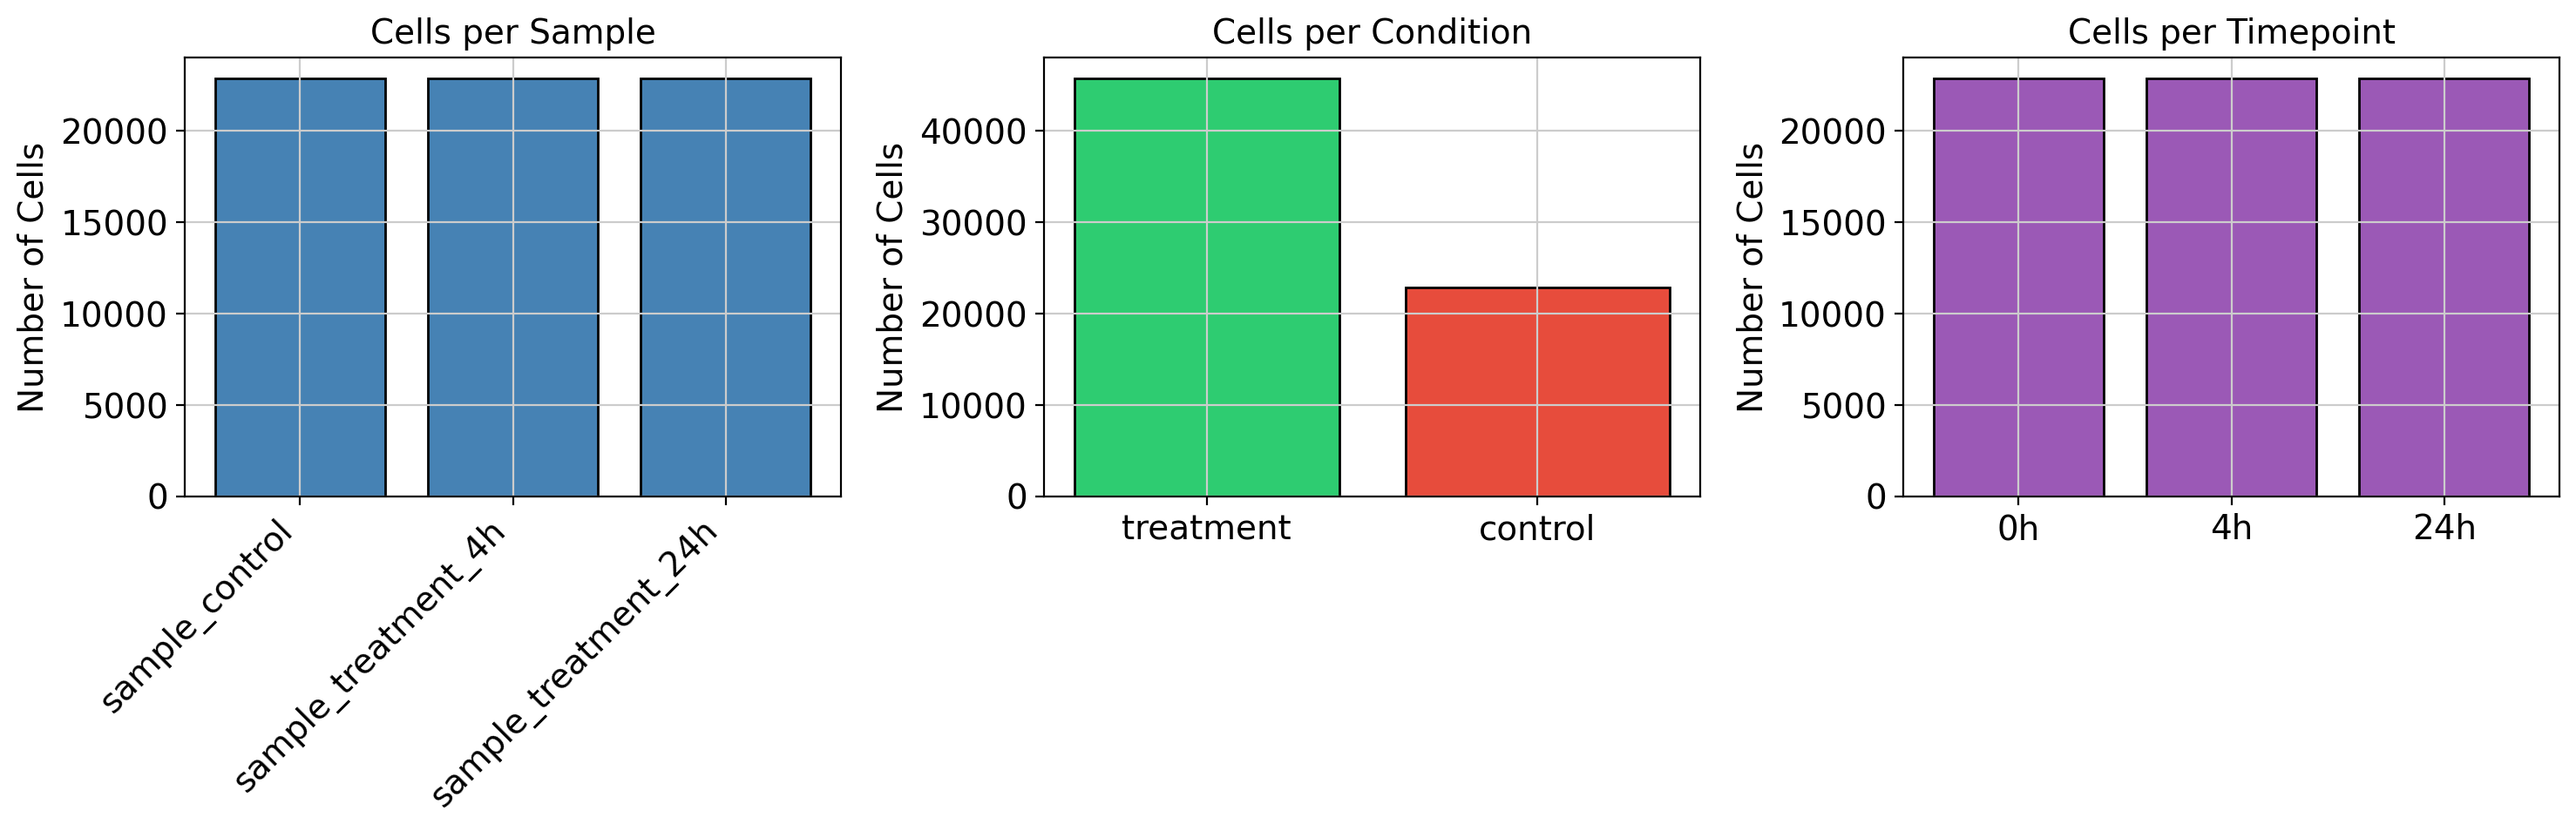

In [16]:
# =============================================================================
# CELL 14: Visualization — Sample Composition
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Cells per sample
sample_counts = adata_merged.obs['sample'].value_counts()
axes[0].bar(range(len(sample_counts)), sample_counts.values, color='steelblue', edgecolor='black')
axes[0].set_xticks(range(len(sample_counts)))
axes[0].set_xticklabels(sample_counts.index, rotation=45, ha='right')
axes[0].set_ylabel('Number of Cells')
axes[0].set_title('Cells per Sample')

# Plot 2: Cells per condition
condition_counts = adata_merged.obs['condition'].value_counts()
axes[1].bar(condition_counts.index, condition_counts.values, 
            color=['#2ecc71', '#e74c3c'], edgecolor='black')
axes[1].set_ylabel('Number of Cells')
axes[1].set_title('Cells per Condition')

# Plot 3: Cells per timepoint
tp_counts = adata_merged.obs['timepoint'].value_counts().sort_index()
axes[2].bar(tp_counts.index, tp_counts.values, color='#9b59b6', edgecolor='black')
axes[2].set_ylabel('Number of Cells')
axes[2].set_title('Cells per Timepoint')

plt.tight_layout()

# Save figure
fig_path = DIRS["results"] / "sample_composition.png"
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"Figure saved: {fig_path}")

plt.show()

In [17]:
# =============================================================================
# CELL 15: Final Disk Usage Check
# =============================================================================

print("Final Disk Usage Summary:")
print("="*50)

# Check each directory
for name, path in DIRS.items():
    if path.exists():
        total_size = sum(f.stat().st_size for f in path.rglob('*') if f.is_file())
        print(f"  {name}: {total_size / (1024**2):.1f} MB")

_, _, free = shutil.disk_usage(WORKING_DIR)
print(f"\n  Remaining disk space: {free / (1024**3):.1f} GB")
print("="*50)

Final Disk Usage Summary:
  root: 3284.0 MB
  reference: 408.9 MB
  raw_data: 2711.9 MB
  output: 130.5 MB
  processed: 32.7 MB
  results: 0.1 MB

  Remaining disk space: 16.3 GB


In [18]:
# =============================================================================
# CELL 16: Workflow Summary and Next Steps
# =============================================================================

print("""
╔══════════════════════════════════════════════════════════════════════╗
║                  KAGGLE WORKFLOW COMPLETED SUCCESSFULLY              ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  Your merged single-cell dataset is ready for downstream analysis!  ║
║                                                                      ║
║  📁 Output Files:                                                    ║
""")
print(f"║     {DIRS['processed']}")
print("""
║                                                                      ║
║  📊 Dataset Statistics:                                              ║
""")
print(f"║     • Total Cells: {adata_merged.n_obs:,}")
print(f"║     • Total Genes: {adata_merged.n_vars:,}")
print(f"║     • Samples: {len(sample_ids)}")
print("""
║                                                                      ║
║  📥 To Download Your Results:                                        ║
║     1. Go to the 'Output' tab on the right panel                     ║
║     2. Find 'processed_data/merged_data.h5ad'                        ║
║     3. Click the download icon                                       ║
║                                                                      ║
║  🔬 Recommended Next Steps:                                          ║
║     1. Quality Control (filter low-quality cells)                    ║
║     2. Normalization and Log-transformation                          ║
║     3. Feature Selection (highly variable genes)                     ║
║     4. Dimensionality Reduction (PCA, UMAP)                          ║
║     5. Clustering (Leiden algorithm)                                 ║
║     6. Differential Expression Analysis                              ║
║                                                                      ║
╚══════════════════════════════════════════════════════════════════════╝
""")

# Code snippet for loading
print("\nTo load this data in another notebook:")
print("-"*50)
print(f'''
import scanpy as sc

# If continuing in same Kaggle session:
adata = sc.read_h5ad("{merged_path}")

# If loading from downloaded file:
# adata = sc.read_h5ad("merged_data.h5ad")

print(adata)
''')


╔══════════════════════════════════════════════════════════════════════╗
║                  KAGGLE WORKFLOW COMPLETED SUCCESSFULLY              ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  Your merged single-cell dataset is ready for downstream analysis!  ║
║                                                                      ║
║  📁 Output Files:                                                    ║

║     /kaggle/working/processed_data

║                                                                      ║
║  📊 Dataset Statistics:                                              ║

║     • Total Cells: 68,571
║     • Total Genes: 39,546
║     • Samples: 3

║                                                                      ║
║  📥 To Download Your Results:                                        ║
║     1. Go to the 'Output' tab on the right panel                     ║
║     2. Fi

---

## Appendix A: Using Custom SRA/GEO Datasets

To use your own datasets from SRA/GEO, modify the sample dictionary below:

In [ ]:
# =============================================================================
# APPENDIX: Template for Custom SRA Downloads
# =============================================================================
# Uncomment and modify to download custom datasets.

'''
import json
import subprocess

# Example human brain dataset accessions (replace with your own)
CUSTOM_SAMPLES = {
    "brain_sample_1": {
        "sra_accession": "SRR10668798",
        "condition": "healthy"
    },
    "brain_sample_2": {
        "sra_accession": "SRR10668799",
        "condition": "disease"
    }
}

for sample_id, info in CUSTOM_SAMPLES.items():
    accession = info["sra_accession"]
    print(f"Fetching URLs for {accession}...")
    
    # Get download URLs using ffq
    result = subprocess.run(
        ["ffq", "--ftp", accession],
        capture_output=True,
        text=True
    )
    
    data = json.loads(result.stdout)
    
    # Download files
    sample_dir = DIRS["raw_data"] / sample_id
    sample_dir.mkdir(exist_ok=True)
    
    for entry in data:
        url = entry["url"]
        filename = os.path.basename(url)
        output_path = sample_dir / filename
        
        if not output_path.exists():
            print(f"  Downloading {filename}...")
            !wget -q -O {output_path} {url}
'''

---

## Appendix B: Small Human Brain Dataset Accessions

Here are some smaller human brain scRNA-seq datasets suitable for testing:

| GEO Accession | Description | Approximate Size |
|--------------|-------------|------------------|
| GSE67835 | Adult brain cortex (Darmanis et al.) | Small (~500 cells) |
| GSE75140 | Brain organoids (Camp et al.) | Small (~700 cells) |
| GSE76381 | Human midbrain (La Manno et al.) | Medium (~4k cells) |
| GSE97930 | Human brain development | Medium |

**Note:** Some older datasets use plate-based protocols (Smart-seq2) rather than 10x. For 10x data, look for datasets mentioning "10x Genomics" or "Chromium" in their descriptions.

### Larger Brain Atlases (Require More Resources):
- **Allen Brain Atlas** — https://portal.brain-map.org/
- **CellxGene** — https://cellxgene.cziscience.com/ (pre-processed h5ad files)
- **NeMO Archive** — https://nemoarchive.org/

---

## Appendix C: Troubleshooting

### Common Kaggle-Specific Issues

**1. Disk space exceeded (20 GB limit)**
- Delete raw FASTQs after processing
- Clean up reference transcriptome files
- Upload large input files as Kaggle Datasets

**2. Session timed out during processing**
- Keep the browser tab active
- Process fewer samples per session
- Download intermediate results frequently

**3. "Illegal instruction" error**
```python
# Use --opt-off flag to disable CPU optimizations
!kb ref --opt-off -d human -i index.idx -g t2g.txt
```

**4. Memory error during merging**
- Kaggle has 29 GB RAM, which should be sufficient
- If issues persist, process and save samples individually
- Use `adata.write_h5ad()` with compression